<td>
    <a target="_blank" href="https://colab.research.google.com/github/jjerry-k/learning_framework/blob/main/03_Advance/Segmentation/U-Net/PyTorch.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
</td>

In [1]:
# Importing Modules
import os
import random
from tqdm import tqdm

import numpy as np
from PIL import Image

import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader 

from torchvision import transforms

from matplotlib import pyplot as plt

# Device Configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Set randomness
seed = 777
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) # if use multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set hyperparameter
epochs= 10
batch_size= 32
img_size= 192

In [2]:
# Dataset
class HorseDataset(Dataset):
    def __init__(self, data_dir, transform):
        IMG_FORMAT = ["jpg", "jpeg", "bmp", "png", "tif", "tiff"]
        self.img_root = os.path.join(data_dir, "jpg")
        self.lab_root = os.path.join(data_dir, "gt")

        self.img_list = [file for file in sorted(os.listdir(self.img_root)) if file.split(".")[-1] in IMG_FORMAT]
        self.lab_list = [file for file in sorted(os.listdir(self.lab_root)) if file.split(".")[-1] in IMG_FORMAT]
        
        for img, lab in zip(self.img_list, self.lab_list):
            img_filename = img.split(".")[0]
            lab_filename = lab.split(".")[0]
            if img_filename != lab_filename: 
                raise RuntimeError(f"File name NOT same {img} {lab}")

        self.transform = transform

    def __len__(self):
        # return size of dataset
        return len(self.img_list)

    def __getitem__(self, idx):

        image = Image.open(os.path.join(self.img_root, self.img_list[idx])).convert("RGB")
        image = self.transform(image)
        label = Image.open(os.path.join(self.lab_root, self.lab_list[idx])).convert("L")
        label = self.transform(label).squeeze()
        return image, label

transform = transforms.Compose([
                                transforms.Resize((img_size, img_size)), transforms.ToTensor()
                                ])
train_dataset = HorseDataset(os.path.join("../../../data/horses/train"), transform)
val_dataset = HorseDataset(os.path.join("../../../data/horses/validation"), transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

In [3]:
# Defining Model
class Conv_Block(nn.Module):
    '''(Conv, ReLU) * 2'''
    def __init__(self, in_ch, out_ch, pool=None):
        super(Conv_Block, self).__init__()
        layers = [
                    nn.Conv2d(in_ch, out_ch, 3, padding=1),
                    nn.BatchNorm2d(out_ch),
                    nn.ReLU(inplace=True),
                    nn.Conv2d(out_ch, out_ch, 3, padding=1),
                    nn.BatchNorm2d(out_ch),
                    nn.ReLU(inplace=True)
                    ]
        
        if pool:
            layers.insert(0, nn.MaxPool2d(2, 2))
        
        self.conv = nn.Sequential(*layers)
            

    def forward(self, x):
        x = self.conv(x)
        return x


class Upconv_Block(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(Upconv_Block, self).__init__()

        self.upconv = nn.ConvTranspose2d(in_ch, in_ch//2, 2, stride=2)
        
        self.conv = Conv_Block(in_ch, out_ch)

    def forward(self, x1, x2):
        # x1 : unpooled feature
        # x2 : encoder feature
        x1 = self.upconv(x1)
        x1 = nn.UpsamplingBilinear2d(x2.size()[2:])(x1)
        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x

class UNet(nn.Module):
    def __init__(self, input_channel=3, num_classes=5):
        super(UNet, self).__init__()
        self.conv1 = Conv_Block(input_channel, 64)
        self.conv2 = Conv_Block(64, 128, pool=True)
        self.conv3 = Conv_Block(128, 256, pool=True)
        self.conv4 = Conv_Block(256, 512, pool=True)
        self.conv5 = Conv_Block(512, 1024, pool=True)
        
        self.unconv4 = Upconv_Block(1024, 512)
        self.unconv3 = Upconv_Block(512, 256)
        self.unconv2 = Upconv_Block(256, 128)
        self.unconv1 = Upconv_Block(128, 64)
        
        self.prediction = nn.Conv2d(64, num_classes, 1)
        
        self.init_weights()

    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        en1 = self.conv1(x) #/2
        en2 = self.conv2(en1) #/4
        en3 = self.conv3(en2) #/8
        en4 = self.conv4(en3) #/16
        en5 = self.conv5(en4) 
        
        de4 = self.unconv4(en5, en4) # /8
        de3 = self.unconv3(de4, en3) # /4
        de2 = self.unconv2(de3, en2) # /2
        de1 = self.unconv1(de2, en1) # /1
        
        output = self.prediction(de1)
        return output

class CrossEntropyLoss2d(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(CrossEntropyLoss2d, self).__init__()
        self.nll_loss = nn.NLLLoss()

    def forward(self, inputs, targets):
        return self.nll_loss(nn.functional.log_softmax(inputs, dim=1), targets)

num_classes = 2
model = UNet(input_channel=3, num_classes=num_classes).to(device)
criterion = CrossEntropyLoss2d()
optimizer = optim.Adam(model.parameters(), lr=0.001)  


In [4]:
# Training

def calc_iou(pred, label):
    # pred: [B, H, W]
    # label: [B, H, W]

    intersection = (pred * label).sum(dim=(1, 2))
    union = (pred + label).sum(dim=(1, 2)) - intersection
    iou = (intersection + 1e-5)/(union + 1e-5)
    return iou

for epoch in range(epochs):
    model.train()
    avg_loss = 0
    avg_iou = 0

    with tqdm(total=len(train_loader)) as t:
        t.set_description(f'[{epoch+1}/{epochs}]')
        total = 0
        iou = 0
        for i, (batch_img, batch_lab) in enumerate(train_loader):
            X = batch_img.to(device)
            Y = batch_lab.type(torch.LongTensor).to(device)
            y_pred = model.forward(X)
            loss = criterion(y_pred, Y)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            avg_loss += loss.item()
            
            predicted = torch.argmax(y_pred, dim=1)
            total += Y.size(0)
            iou += calc_iou(predicted, Y).mean().item()

            t.set_postfix({"loss": f"{avg_loss/(i+1):05.3f}"})
            t.update()
        avg_iou += iou

    model.eval()
    with tqdm(total=len(val_loader)) as t:
        t.set_description(f'[{epoch+1}/{epochs}]')
        with torch.no_grad():
            val_loss = 0
            val_iou = 0
            total = 0
            for i, (batch_img, batch_lab) in enumerate(val_loader):
                X = batch_img.to(device)
                Y = batch_lab.type(torch.LongTensor).to(device)
                y_pred = model(X)
                val_loss += criterion(y_pred, Y)
                predicted = torch.argmax(y_pred, dim=1)
                total += Y.size(0)
                val_iou += calc_iou(predicted, Y).mean()
                t.set_postfix({"val_loss": f"{val_loss.item()/(i+1):05.3f}"})
                t.update()
            val_loss /= len(val_loader)
            val_iou /= len(val_loader)
            
    print(f"Epoch : {epoch+1}, Loss : {(avg_loss/len(train_loader)):.3f}, IoU: {avg_iou/len(train_loader):.3f}, Val Loss : {val_loss.item():.3f}, Val IoU : {val_iou.item():.3f}\n")

print("Training Done !")

[1/10]: 100%|██████████| 2/2 [00:00<00:00,  2.41it/s, val_loss=290.562]


Epoch : 1, Loss : 0.632, IoU: 0.298, Val Loss : 290.562, Val IoU : 0.119



[2/10]: 100%|██████████| 2/2 [00:00<00:00,  2.30it/s, val_loss=7.658]


Epoch : 2, Loss : 0.367, IoU: 0.303, Val Loss : 7.658, Val IoU : 0.206



[3/10]: 100%|██████████| 2/2 [00:00<00:00,  2.44it/s, val_loss=0.747]


Epoch : 3, Loss : 0.334, IoU: 0.362, Val Loss : 0.747, Val IoU : 0.367



[4/10]: 100%|██████████| 2/2 [00:00<00:00,  2.33it/s, val_loss=6.614] 


Epoch : 4, Loss : 0.308, IoU: 0.405, Val Loss : 6.614, Val IoU : 0.341



[5/10]: 100%|██████████| 2/2 [00:00<00:00,  2.11it/s, val_loss=0.338]


Epoch : 5, Loss : 0.278, IoU: 0.459, Val Loss : 0.338, Val IoU : 0.518



[6/10]: 100%|██████████| 2/2 [00:00<00:00,  2.08it/s, val_loss=0.405]


Epoch : 6, Loss : 0.249, IoU: 0.525, Val Loss : 0.405, Val IoU : 0.425



[7/10]: 100%|██████████| 2/2 [00:00<00:00,  2.20it/s, val_loss=0.283]


Epoch : 7, Loss : 0.213, IoU: 0.591, Val Loss : 0.283, Val IoU : 0.576



[8/10]: 100%|██████████| 2/2 [00:00<00:00,  2.30it/s, val_loss=0.274]


Epoch : 8, Loss : 0.211, IoU: 0.597, Val Loss : 0.274, Val IoU : 0.535



[9/10]: 100%|██████████| 2/2 [00:00<00:00,  2.33it/s, val_loss=0.174]


Epoch : 9, Loss : 0.193, IoU: 0.626, Val Loss : 0.174, Val IoU : 0.612



[10/10]: 100%|██████████| 2/2 [00:00<00:00,  2.22it/s, val_loss=0.197]

Epoch : 10, Loss : 0.186, IoU: 0.640, Val Loss : 0.197, Val IoU : 0.621

Training Done !


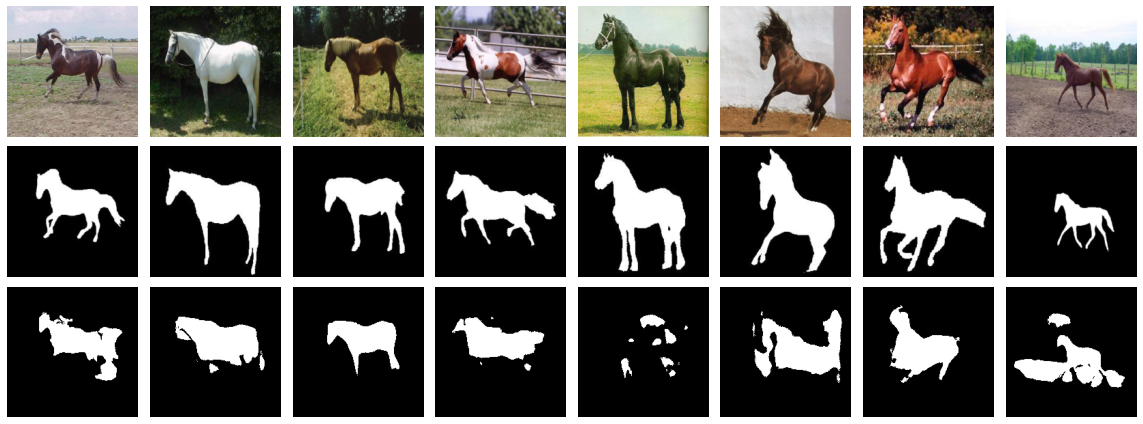

In [5]:
# Sample
for images, labels in val_loader:
    break

num_sample = 8
num_sample = num_sample if num_sample < batch_size else batch_size
col = num_sample
row = 3

sample_image = images[:num_sample].to(device)
sample_label = labels[:num_sample]
prediction = torch.argmax(model(sample_image), dim=1).cpu().detach()

plt.figure(figsize=(col*2, row*2))

for i in range(num_sample):
    # 1st row: Input image 
    plt.subplot(row, col, i+1)
    plt.imshow(sample_image[i].permute(1, 2, 0).cpu())
    plt.axis("off")

    # 2nd row: Label image
    plt.subplot(row, col, (i+1)+num_sample)
    plt.imshow(sample_label[i].cpu(), cmap="gray")
    plt.axis("off")
    
    # 3rd row: Predicted image
    plt.subplot(row, col, (i+1)+num_sample*2)
    plt.imshow(prediction[i].cpu(), cmap="gray")
    plt.axis("off")
plt.tight_layout()
plt.show()